In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import pickle

In [2]:
# utils

def save_object(object_to_save, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(object_to_save, file)

def load_object(file_path):
    with open(file_path, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object

In [3]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.shape

(1338, 7)

In [5]:
# introducing some nulls
def introduce_random_nans(df):
    for col in df.columns:
        if col == 'charges':
            continue
        num_nan = int(len(df) * round(np.random.uniform(0, 0.1),3))
        nan_indices = np.random.choice(df.index, num_nan, replace=False)
        df.loc[nan_indices, col] = np.nan
    return df

data = introduce_random_nans(data)

**Data Analysis**

In [6]:
data.isnull().sum()

age           1
sex          68
bmi          97
children    129
smoker       56
region      132
charges       0
dtype: int64

In [7]:
# age
data['age'].min(), data['age'].max()

(18.0, 64.0)

In [8]:
# sex
data['sex'].value_counts()

male      640
female    630
Name: sex, dtype: int64

In [9]:
# bmi
data['bmi'].min(), data['bmi'].max()

(15.96, 53.13)

In [10]:
# children
data['children'].min(), data['children'].max()

(0.0, 5.0)

In [11]:
# smoker
data['smoker'].value_counts()

no     1022
yes     260
Name: smoker, dtype: int64

In [12]:
# region
data['region'].value_counts()

southeast    336
southwest    292
northwest    290
northeast    288
Name: region, dtype: int64

In [13]:
# charges
data['charges'].min(), data['charges'].max()

(1121.8739, 63770.42801)

In [14]:
# I want to check who these people are

data[data['charges'] == data['charges'].min()]

,age,sex,bmi,children,smoker,region,charges
940,18.0,male,23.21,0.0,no,southeast,1121.8739


In [15]:
data[data['charges'] == data['charges'].max()]

,age,sex,bmi,children,smoker,region,charges
543,54.0,female,47.41,0.0,yes,southeast,63770.42801


In [16]:
data[data['bmi'] == data['bmi'].max()]

,age,sex,bmi,children,smoker,region,charges
1317,18.0,male,53.13,NaN,no,southeast,1163.4627


**Data Preprocessing**

In [17]:
# Fixing Nulls

# if null % is less, then you can drop them
# you can fill with mean or median
# use ML techniques to fill missing values

data.isnull().sum()

age           1
sex          68
bmi          97
children    129
smoker       56
region      132
charges       0
dtype: int64

In [18]:
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

In [19]:
for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col + "_na"] = data[col].isnull().astype(int)

data.head()

,age,sex,bmi,children,smoker,region,charges,age_na,sex_na,bmi_na,children_na,smoker_na,region_na
0,19.0,female,NaN,0.0,yes,southwest,16884.92400,0,0,1,0,0,0
1,18.0,male,33.770,1.0,no,southeast,1725.55230,0,0,0,0,0,0
2,28.0,male,33.000,3.0,no,southeast,4449.46200,0,0,0,0,0,0
3,33.0,male,22.705,0.0,no,northwest,21984.47061,0,0,0,0,0,0
4,32.0,male,28.880,0.0,no,northwest,3866.85520,0,0,0,0,0,0


In [20]:
column_modes = {}

for col in categorical_features:
    mode_val = data[col].mode()[0]
    column_modes[col] = mode_val
    data[col].fillna(value=mode_val, inplace=True)

data.isnull().sum()

age              1
sex              0
bmi             97
children       129
smoker           0
region           0
charges          0
age_na           0
sex_na           0
bmi_na           0
children_na      0
smoker_na        0
region_na        0
dtype: int64

In [21]:
column_modes

{'sex': 'male', 'smoker': 'no', 'region': 'southeast'}

<Axes: ylabel='age'>

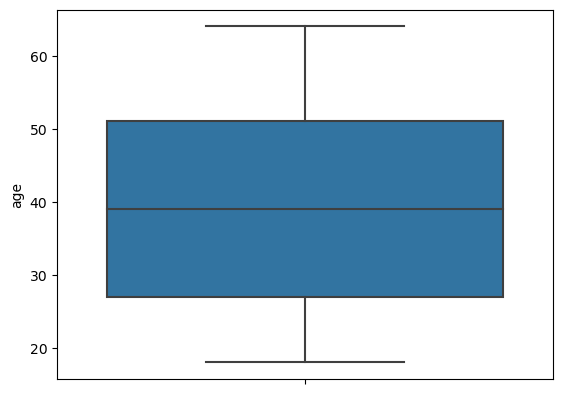

In [22]:
# Identify Outliers
sns.boxplot(y = 'age', data=data)

<Axes: ylabel='bmi'>

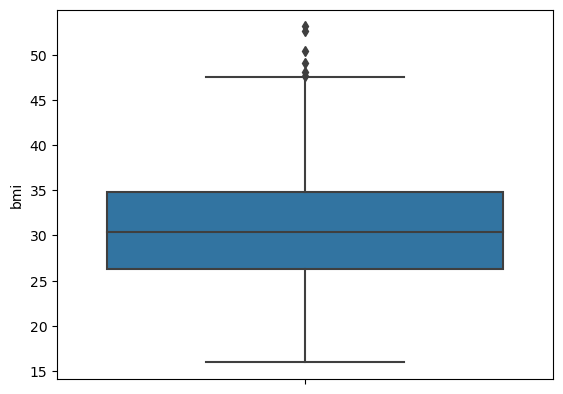

In [23]:
sns.boxplot(y = 'bmi', data=data)

<Axes: ylabel='children'>

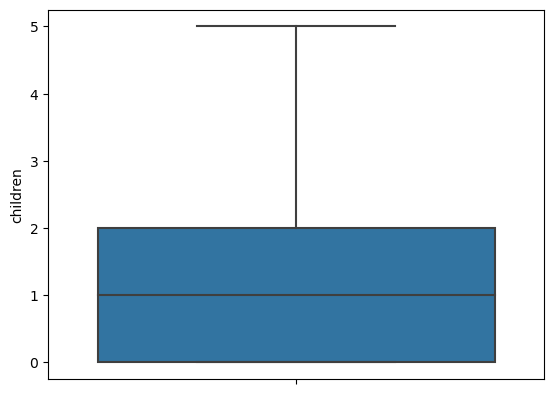

In [24]:
sns.boxplot(y = 'children', data=data)

In [25]:
# Fix Outliers
# 1. Remove outliers
# 2. Replacing Outliers with mean or median
# 3. Clipping Outliers - np.clip()

# 1. Natural Outliers -
#   1. mean, median, clipping
# 2. Instrument or Manual Error -
#   1. mean, median, clipping

In [26]:
# IQR
# upper limit = q3 + 1.5*(q3 - q1)

# Need to identify outlier
outlier_stats = {}
outliers_identification_cols = ['age', 'bmi', 'children']

for col in outliers_identification_cols:
    q3, q1 = data[col].quantile(0.75), data[col].quantile(0.25)
    upper_limit = q3 + 1.5*(q3 - q1)
    lower_limit = q1 - 1.5*(q3 - q1)

    outlier_stats[col] = {'lower_limit': lower_limit, 'upper_limit': upper_limit}

    outlier_indexes = data.index[(data[col] > upper_limit) | (data[col] < lower_limit)]
    data.loc[outlier_indexes, col] = np.nan

In [27]:
outlier_stats

{'age': {'lower_limit': -9.0, 'upper_limit': 87.0},
 'bmi': {'lower_limit': 13.587500000000007, 'upper_limit': 47.52749999999999},
 'children': {'lower_limit': -3.0, 'upper_limit': 5.0}}

In [28]:
# Save KNNImputer
Imputer = KNNImputer()
# Imputer.fit(data[numerical_features])
# data.loc[:, numerical_features] = Imputer.transform(data[numerical_features])

data.loc[:, numerical_features] = Imputer.fit_transform(data[numerical_features])
data.isnull().sum()

age            0
sex            0
bmi            0
children       0
smoker         0
region         0
charges        0
age_na         0
sex_na         0
bmi_na         0
children_na    0
smoker_na      0
region_na      0
dtype: int64

In [29]:
# Include these changes in realtime code
def round_it_off(values):
    return np.floor(values + 0.5).astype(int)

data['age'] = round_it_off(data['age'].values)
data['children'] = round_it_off(data['children'].values)

data.head()

,age,sex,bmi,children,smoker,region,charges,age_na,sex_na,bmi_na,children_na,smoker_na,region_na
0,19,female,29.116,0,yes,southwest,16884.92400,0,0,1,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0,0,0,0
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0,0,0,0
3,33,male,22.705,0,no,northwest,21984.47061,0,0,0,0,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,0,0,0,0


In [30]:
# Handling Categorical Data

# Save individual Label Encoders
def applyLabelEncoder(data, col):
    Le = LabelEncoder()
    data.loc[:, col] = Le.fit_transform(data[col])
    return data, Le

In [31]:
column_Le = {}

In [32]:
for col in ['sex', 'smoker']:
    data, Le = applyLabelEncoder(data, col)
    # data = applyLabelEncoder(data, 'smoker')
    column_Le[col] = Le

data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_24744\3318940306.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, col] = Le.fit_transform(data[col])
C:\Users\Admin\AppData\Local\Temp\ipykernel_24744\3318940306.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, col] = Le.fit_transform(data[col])


,age,sex,bmi,children,smoker,region,charges,age_na,sex_na,bmi_na,children_na,smoker_na,region_na
0,19,0,29.116,0,1,southwest,16884.92400,0,0,1,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,0,0,0,0
2,28,1,33.000,3,0,southeast,4449.46200,0,0,0,0,0,0
3,33,1,22.705,0,0,northwest,21984.47061,0,0,0,0,0,0
4,32,1,28.880,0,0,northwest,3866.85520,0,0,0,0,0,0


In [33]:
column_Le

{'sex': LabelEncoder(), 'smoker': LabelEncoder()}

In [34]:
def applyOHE(data, col):
    Ohe = OneHotEncoder(sparse_output = False)
    ohe_output = Ohe.fit_transform(data[[col]]) # returns 2d numpy array
    col_names = [col + "_" + val for val in Ohe.categories_[0]]
    ohe_output = pd.DataFrame(ohe_output[:,:-1], columns=col_names[:-1])
    data.drop([col], axis=1, inplace=True)
    data = pd.concat([data, ohe_output], axis=1)
    return data, Ohe

In [35]:
column_Ohe = {}

# Save OneHotEncoder
for col in ['region']:
    data, Ohe = applyOHE(data, col)
    column_Ohe[col] = Ohe

data.head()

,age,sex,bmi,children,smoker,charges,age_na,sex_na,bmi_na,children_na,smoker_na,region_na,region_northeast,region_northwest,region_southeast
0,19,0,29.116,0,1,16884.92400,0,0,1,0,0,0,0.0,0.0,0.0
1,18,1,33.770,1,0,1725.55230,0,0,0,0,0,0,0.0,0.0,1.0
2,28,1,33.000,3,0,4449.46200,0,0,0,0,0,0,0.0,0.0,1.0
3,33,1,22.705,0,0,21984.47061,0,0,0,0,0,0,0.0,1.0,0.0
4,32,1,28.880,0,0,3866.85520,0,0,0,0,0,0,0.0,1.0,0.0


In [36]:
# Apply Scaling

# Linear, Lasso, Ridge - Scaling is compulsory
cols_to_scale = ['age', 'bmi', 'children']

# Save Scaler
# Scaler = StandardScaler()
Scaler = MinMaxScaler()
data.loc[:, cols_to_scale] = Scaler.fit_transform(data[cols_to_scale])

**Model Building**

In [37]:
X = data.drop(['charges'], axis=1)
Y = data['charges']

In [38]:
X

,age,sex,bmi,children,smoker,age_na,sex_na,bmi_na,children_na,smoker_na,region_na,region_northeast,region_northwest,region_southeast
0,0.021739,0,0.416857,0.0,1,0,0,1,0,0,0,0.0,0.0,0.0
1,0.000000,1,0.564322,0.2,0,0,0,0,0,0,0,0.0,0.0,1.0
2,0.217391,1,0.539924,0.6,0,0,0,0,0,0,0,0.0,0.0,1.0
3,0.326087,1,0.213720,0.0,0,0,0,0,0,0,0,0.0,1.0,0.0
4,0.304348,1,0.409379,0.0,0,0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,1,0.475602,0.6,0,0,0,0,0,0,0,0.0,1.0,0.0
1334,0.000000,0,0.505703,0.0,0,0,0,0,0,0,0,1.0,0.0,0.0
1335,0.000000,0,0.661914,0.0,0,0,0,0,0,0,0,0.0,0.0,1.0
1336,0.065217,0,0.311787,0.2,0,0,0,0,1,0,0,0.0,0.0,0.0


In [39]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.15, random_state = 4)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [41]:
model = LinearRegression()
model.fit(Xtrain, Ytrain)
print(" Training R2 Score : ", model.score(Xtrain, Ytrain))
print(" Testing R2 Score : ", model.score(Xtest, Ytest))

 Training R2 Score :  0.7372151223967156
 Testing R2 Score :  0.617876157562047


In [42]:
model = SVR(C=2)
model.fit(Xtrain, Ytrain)
print(" Training R2 Score : ", model.score(Xtrain, Ytrain))
print(" Testing R2 Score : ", model.score(Xtest, Ytest))

 Training R2 Score :  -0.09798394429568513
 Testing R2 Score :  -0.042492335561470806


In [43]:
# Store the model
model = RandomForestRegressor(min_samples_split=11, max_features=0.5, oob_score=True)
model.fit(X, Y)
# print(" Training R2 Score : ", model.score(Xtrain, Ytrain))
# print(" Testing R2 Score : ", model.score(Xtest, Ytest))
model.oob_score_

0.7982405200747622

In [44]:
# model = GradientBoostingRegressor(learning_rate=0.1)
# model.fit(Xtrain, Ytrain)
# print(" Training R2 Score : ", model.score(Xtrain, Ytrain))
# print(" Testing R2 Score : ", model.score(Xtest, Ytest))

In [45]:
# save model
# write deployment pipeline

In [46]:
# Object Oriented Programming python

In [47]:
class Model:
    def __init__(self, column_modes, outlier_stats, Imputer, column_Le, column_Ohe, Scaler, model):
        self.column_modes = column_modes
        self.outlier_stats = outlier_stats
        self.Imputer = Imputer
        self.column_Le = column_Le
        self.column_Ohe = column_Ohe
        self.Scaler = Scaler
        self.model = model

In [48]:
ModelRF = Model(column_modes, outlier_stats, Imputer, column_Le, column_Ohe, Scaler, model)

In [49]:
ModelRF.model

RandomForestRegressor(max_features=0.5, min_samples_split=11, oob_score=True)

In [50]:
ModelRF.Scaler

MinMaxScaler()

In [51]:
save_object(ModelRF, "ModelRF.pck")

In [52]:
# Data Scientists - build model, build pipeline/deployment script
# Backend Team (APIs) - creating API for your code
# Frontend Team (website)